In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image = plt.imread('Image/test_lane.jpg')
im2 = plt.imread('Image/road-line-detection.jpeg')

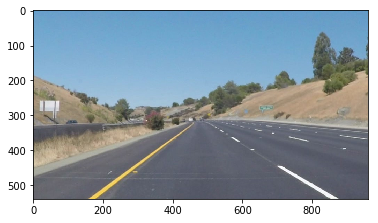

In [3]:
plt.imshow(im2)

In [4]:
im2.shape

(540, 960, 3)

In [5]:
def canny_edge(img):
    """
    This function takes an image, return edges detected in it
    it can work for both gray and colored images.
    """
    if len(img.shape) > 2:
        assert len(img.shape) == 3, "expected a 3d array at most"
        #copy image
        copy_img = img.copy()
        #convert to gray scale
        gray_img = cv2.cvtColor(copy_img, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = img.copy()
    
    #gaussian blur
    blur_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    
    #canny edge detection
    canny_img = cv2.Canny(blur_img, 50, 150)
    
    return canny_img


def region_of_interest(img):
    """
    This function returns an enclosed region 
    of our field of view.
    
    arguments:
    img -> a canny edge detected image.
    """
    
    height = image.shape[0]
    polygons = np.array([
        [(150, height), (900, height), (550, 250)]
    ])
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, polygons, 255) #255 will be the color of the polygon
    
    #bitwise and
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img


def make_coordinates(img, line_parameters):
    slope, intercept = line_parameters
    y1 = img.shape[0]
    # we want the height of the new line to be 3/5 of the y-axis
    y2 = int(y1 * (3/5))
    # re-arranging y= mx + b we can get the x-coordinate values
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    #the maths above allows both of our lines to have 
    #the same vertical coordinates
    return np.array([x1, y1, x2, y2])

def average_slope_intercept(img, lines):
    left_fit = []
    right_fit = []
    
    for line in lines:
        x1, y1, x2, y2 =line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line = make_coordinates(img, left_fit_average)
    right_line = make_coordinates(img, right_fit_average)
    
    return np.array([left_line, right_line])


def display_lines(img, lines):
    line_img = np.zeros_like(img)
    #lines will be a 3d array
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line
            #let's draw the line one our line_img mask
            #with BGR color of blue and line thickness of 10
            cv2.line(line_img, (x1,y1), (x2, y2), (255, 0, 0), 10)
    return line_img

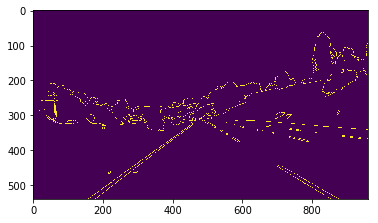

In [6]:
# import image
#image = cv2.imread('image/test_lane.jpg')
image = cv2.imread('Image/road-line-detection.jpeg')
# create a copy to work with
lane_image = np.copy(image)

#find edges in the image
canny_image = canny_edge(lane_image)

plt.imshow(canny_image)

In [7]:
lane_image.shape

(540, 960, 3)

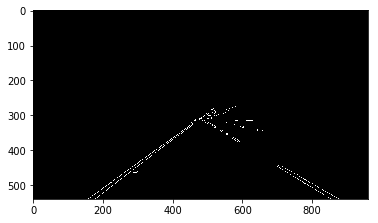

In [8]:
#identify your region of interest
roi_image = region_of_interest(canny_image)
plt.imshow(roi_image, cmap='gray')

In [9]:
#aply hough transform
detected_lines = cv2.HoughLinesP(roi_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
detected_lines

array([[[228, 500, 460, 325]],

       [[160, 539, 217, 497]],

       [[160, 538, 382, 377]],

       [[741, 471, 851, 539]],

       [[712, 445, 874, 538]],

       [[179, 539, 230, 500]],

       [[700, 446, 781, 497]],

       [[420, 350, 460, 321]],

       [[341, 407, 434, 341]]], dtype=int32)

In [10]:
#apply hough transform
detected_lines = cv2.HoughLinesP(roi_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
left_fit = []
right_fit = []

for line in detected_lines:
    line.reshape(4)
    x1, y1, x2, y2 =line.reshape(4)
    parameters = np.polyfit((x1, x2), (y1, y2), 1)
    slope = parameters[0]
    intercept = parameters[1]
    if slope < 0:
        left_fit.append((slope, intercept))
    else:
        right_fit.append((slope, intercept))
        
left_fit_average = np.average(left_fit, axis=0)
right_fit_average = np.average(right_fit, axis=0)

In [11]:
right_fit

[(0.6181818181818173, 12.927272727273449),
 (0.5740740740740748, 36.259259259258506),
 (0.6296296296296284, 5.259259259260324)]

In [12]:
left_fit

[(-0.7543103448275861, 671.9827586206897),
 (-0.7368421052631593, 656.8947368421055),
 (-0.725225225225225, 654.0360360360362),
 (-0.76470588235294, 675.8823529411761),
 (-0.7250000000000073, 654.5000000000033),
 (-0.7096774193548394, 649.0000000000002)]

In [13]:
left_line = make_coordinates(lane_image, left_fit_average)
right_line = make_coordinates(lane_image, right_fit_average)
np.array([left_line, right_line])

array([[163, 540, 457, 324],
       [859, 540, 503, 324]])

In [14]:
#optimize the detected lines
averaged_lines = average_slope_intercept(lane_image, detected_lines)

In [15]:
averaged_lines

array([[163, 540, 457, 324],
       [859, 540, 503, 324]])

In [16]:
#draw the lines on the a mask image same shape as lane_image
line_image = display_lines(lane_image, averaged_lines)

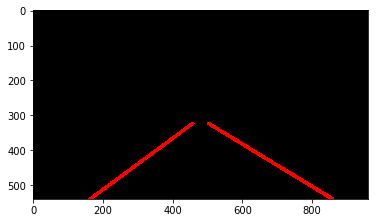

In [17]:
plt.imshow(line_image)

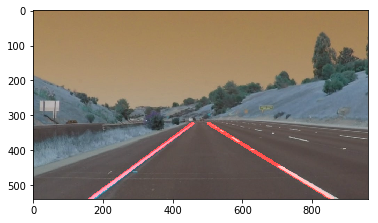

In [18]:
#overlap the optimized lane line mask with the Image.
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
plt.imshow(combo_image)

# Second Image

I'm currently experiencing problems properly sorting the slope for lane lines in this image into left and right fit at one go. since I'm on some sort of "coding sprint" i decided to use a bit of a tricky solution to solve my problem. not optimal and would definitely revisit once i hit my target number of projects. Just a simple reminder to me that complex is better than complicated!and while this solution isn't complicated i had to beak thru a bunch of my functions to get it working properly...

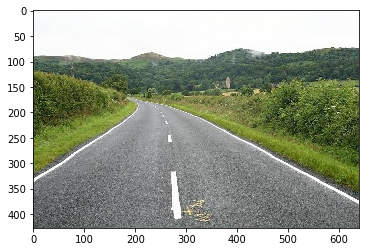

In [19]:
image = plt.imread('Image/test_lane.jpg')
plt.imshow(image)

In [20]:
def canny_edge(img):
    """
    This function takes an image, return edges detected in it
    it can work for both gray and colored images.
    """
    if len(img.shape) > 2:
        assert len(img.shape) == 3, "expected a 3d array at most"
        #copy image
        copy_img = img.copy()
        #convert to gray scale
        gray_img = cv2.cvtColor(copy_img, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = img.copy()
    
    #gaussian blur
    blur_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    
    #canny edge detection
    canny_img = cv2.Canny(blur_img, 50, 150)
    
    return canny_img


def region_of_interest(img):
    """
    This function returns an enclosed region 
    of our field of view.
    
    arguments:
    img -> a canny edge detected image.
    """
    
    height = image.shape[0]
    polygons = np.array([
        [(200, 150), (300, height), (250, 150)]
    ])
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, polygons, 255) #255 will be the color of the polygon
    
    #bitwise and
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img


def make_coordinates(img, line_parameters):
    slope, intercept = line_parameters
    y1 = img.shape[0]
    # we want the height of the new line to be 3/5 of the y-axis
    y2 = int(y1 * (3/5))
    # re-arranging y= mx + b we can get the x-coordinate values
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    #the maths above allows both of our lines to have 
    #the same vertical coordinates
    return np.array([x1, y1, x2, y2])

def average_slope_intercept(img, lines):
    left_fit = []
    right_fit = []
    
    for line in lines:
        x1, y1, x2, y2 =line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line = make_coordinates(img, left_fit_average)
    right_line = make_coordinates(img, right_fit_average)
    
    return np.array([left_line, right_line])


def display_lines(img, lines):
    line_img = np.zeros_like(img)
    #lines will be a 3d array
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line
            #let's draw the line one our line_img mask
            #with BGR color of blue and line thickness of 10
            cv2.line(line_img, (x1,y1), (x2, y2), (255, 0, 0), 10)
    return line_img

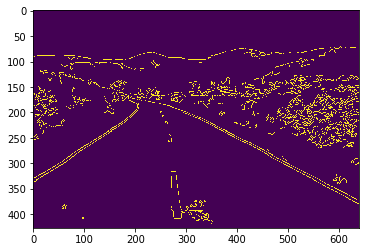

In [21]:
# import image
image = cv2.imread('image/test_lane.jpg')
# create a copy to work with
lane_image = np.copy(image)

#find edges in the image
canny_image = canny_edge(lane_image)

plt.imshow(canny_image)

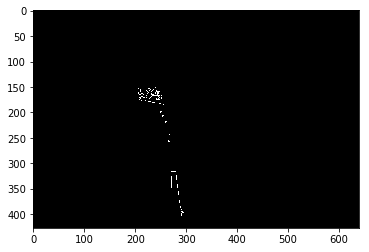

In [22]:
#identify your region of interest
roi_image = region_of_interest(canny_image)
plt.imshow(roi_image, cmap='gray')

In [23]:
#aply hough transform
detected_lines = cv2.HoughLinesP(roi_image, 2, np.pi/180, 50, np.array([]), minLineLength=10, maxLineGap=10)
detected_lines

array([[[265, 244, 267, 258]],

       [[284, 354, 291, 398]],

       [[281, 330, 285, 355]]], dtype=int32)

In [24]:
fit = []
for line in detected_lines:
    line.reshape(4)
    x1, y1, x2, y2 =line.reshape(4)
    parameters = np.polyfit((x1, x2), (y1, y2), 1)
    slope = parameters[0]
    intercept = parameters[1]
    fit.append((slope, intercept))

In [25]:
fit

[(7.0000000000001, -1611.0000000000261),
 (6.285714285714206, -1431.142857142833),
 (6.249999999999952, -1426.2499999999866)]

In [26]:
line_img1 = np.zeros_like(lane_image)
#lines will be a 3d array
if detected_lines is not None:
    for line in detected_lines:
        x1, y1, x2, y2 = line[0]
        #let's draw the line one our line_img mask
        #with BGR color of blue and line thickness of 10
        cv2.line(line_img1, (x1,y1), (x2, y2), (255, 0, 0), 10)

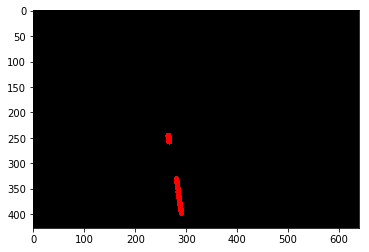

In [27]:
plt.imshow(line_img1)

In [28]:
fit

[(7.0000000000001, -1611.0000000000261),
 (6.285714285714206, -1431.142857142833),
 (6.249999999999952, -1426.2499999999866)]

In [29]:
line_average = np.average(fit, axis=0)
line_average

array([    6.51190476, -1489.46428571])

In [30]:
the_line = make_coordinates(lane_image, line_average)

In [31]:
the_line

array([294, 427, 268, 256])

In [32]:
final_line_img1 = np.zeros_like(lane_image)
#lines will be a 3d array
x1, y1, x2, y2 = the_line
#let's draw the line one our line_img mask
#with BGR color of blue and line thickness of 10
line_drawing1 = cv2.line(final_line_img1, (x1,y1), (x2, y2), (255, 0, 0), 12)

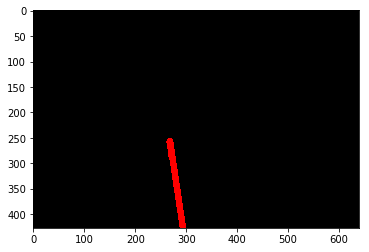

In [33]:
plt.imshow(line_drawing1)

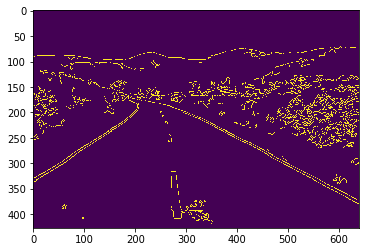

In [34]:
# import image
image = cv2.imread('image/test_lane.jpg')
# create a copy to work with
lane_image = np.copy(image)

#find edges in the image
canny_image = canny_edge(lane_image)

plt.imshow(canny_image)

In [35]:
def region_of_interest(img):
    """
    This function returns an enclosed region 
    of our field of view.
    
    arguments:
    img -> a canny edge detected image.
    """
    
    height = image.shape[0]
    polygons = np.array([
        [(0, 350), (200, height), (180, 150)]
    ])
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, polygons, 255) #255 will be the color of the polygon
    
    #bitwise and
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

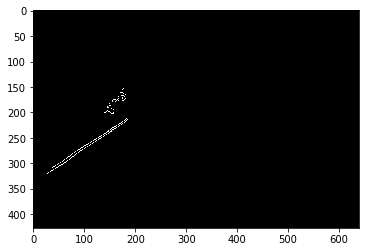

In [36]:
#identify your region of interest
roi_image = region_of_interest(canny_image)
plt.imshow(roi_image, cmap='gray')

In [37]:
#aply hough transform
detected_lines = cv2.HoughLinesP(roi_image, 2, np.pi/180, 50, np.array([]), minLineLength=10, maxLineGap=10)
detected_lines

array([[[ 39, 307, 183, 213]],

       [[ 35, 316, 185, 215]],

       [[ 72, 290, 130, 251]]], dtype=int32)

In [38]:
fit = []
for line in detected_lines:
    line.reshape(4)
    x1, y1, x2, y2 =line.reshape(4)
    parameters = np.polyfit((x1, x2), (y1, y2), 1)
    slope = parameters[0]
    intercept = parameters[1]
    fit.append((slope, intercept))

In [39]:
line_img2 = np.zeros_like(lane_image)
#lines will be a 3d array
if detected_lines is not None:
    for line in detected_lines:
        x1, y1, x2, y2 = line[0]
        #let's draw the line one our line_img mask
        #with BGR color of blue and line thickness of 10
        cv2.line(line_img2, (x1,y1), (x2, y2), (255, 0, 0), 10)

In [40]:
line_average2 = np.average(fit, axis=0)
line_average2

array([ -0.66617497, 336.81293103])

In [41]:
the_second_line = make_coordinates(lane_image, line_average2)

In [42]:
final_line_img2 = np.zeros_like(lane_image)
#lines will be a 3d array
x1, y1, x2, y2 = the_second_line
#let's draw the line one our line_img mask
#with BGR color of blue and line thickness of 10
line_drawing2 = cv2.line(final_line_img2, (x1,y1), (x2, y2), (255, 0, 0), 10)

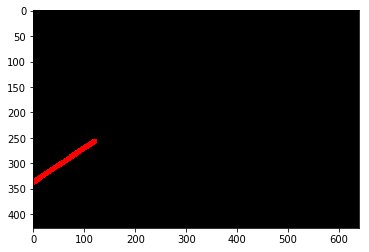

In [43]:
plt.imshow(line_drawing2)

In [44]:
combo_mask_image = cv2.addWeighted(line_drawing1, 1, line_drawing2, 1, 1)

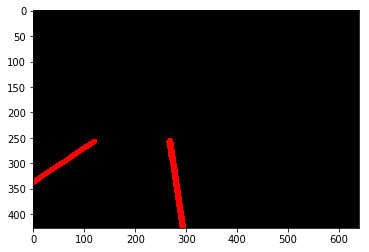

In [45]:
plt.imshow(combo_mask_image)

In [46]:
combo_image = cv2.addWeighted(lane_image, 0.8, combo_mask_image, 1, 1)

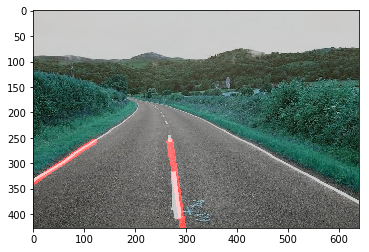

In [47]:
plt.imshow(combo_image)

# Take aways

- This is quite tricky!!.. lol

- I should rewrite the region_of_interest function so i can input a list for the region of interest

- using houghlinesP is quite manual, it still feels like trial n error for me.

- until I return to refactor the code, we move!